<a href="https://www.kaggle.com/michaelsanford/covid-explorer-quebec?scriptVersionId=88021979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Scroll down to see graphs

This analysis is open-source to allow you to see exactly how I have arrived at the provided projections.

Comments and any corrections are most welcome.

Red lines, where present, are forward-looking projectons at 2 X the daily moving average window.

# Notes

* Omicron overwhelmed testing capacity in Quebec. As a result testing has been restricted and the number of true infections _is not known to be representative of the community_ at this time. I originally elected to de-emphasize the raw infection numbers and replace that with test positivity rate but I now include both.

* The following charts are updated at "interesting intervals" (see age at the top, generally daily).
* More populous regions appear near the top.
* The `x DMA` is the x-day (configurable) Daily Moving Average of *active cases* (new - recoveries - deaths).
* `Change` is for the x-day DMA.
* "Quebec" refers to the province as a whole (which is the only jurisdiction that reports Hospitalisations and ICU admissions).

In [1]:
import urllib.request, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

from datetime import date
from os import path

QC = "https://kustom.radio-canada.ca/coronavirus/canada_quebec"

REGIONS = [
    'montreal',
    'monteregie',
    'laval',
    'laurentides',
    'lanaudiere',
    'outaouais',
    'capitale-nationale',
    
    'nunavik',
    'nord-du-quebec',
    'abitibi-temiscamingue',
    'estrie',
    'mauricie-centre-du-quebec',
    'chaudiere-appalaches',
    'bas-saint-laurent',
    'gaspesie-iles-de-la-madeleine',
    'cote-nord',
    'saguenay-lac-saint-jean'
]

# Plot Settings
# plt.style.use('dark_background')
%matplotlib inline

# Notebook settings
warnings.filterwarnings('ignore')

TODAY = date.today().strftime("%Y-%m-%d")

In [2]:
# Data Settings
LAST_DAYS= 700
NTH_LABEL = 8

MA_WINDOW = 4
EXTRAPOLATE_TO = MA_WINDOW * 2

In [3]:
def plot(df, Region=None, Hospitalizations=False, ICU=False, Change=False, MA=False, New=False, Deaths=False, Tests=False, Vaccinations=False, Annotate=True, Extrapolate=False, Positivity=False):
    fig = plt.figure(figsize = (15,10))
    
    if (Hospitalizations and 'H' in df):
        plt.plot(df['H'], label="Hosp. (incl. ICU)", color="cyan")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'H', df, plt)
    
    if (ICU and 'I' in df):
        plt.plot(df['I'], label="ICU", color="deepskyblue")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'I', df, plt)
    
    if (Positivity and 'PMA' in df):
        plt.plot(df['PMA'], label="Positivity Rate (%)", color="chartreuse")

    
    if (Change):
        plt.plot(df['Change'], label="Change", color="royalblue")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'Change', df, plt)
        
    if (MA):
        plt.plot(df['MA'], label="%s DMA (People)" % MA_WINDOW, color="orange")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'MA', df, plt)
        
    if (New):
        plt.plot(df['New'], label="%s DMA New Positive" % MA_WINDOW, color="fuchsia")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'New', df, plt)
        
    if (Deaths):
        plt.plot(df['D'], label="Deaths (Total)", color="black")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'D', df, plt)
            
    if (Vaccinations):
        plt.plot(df['V'], label="Vaccinations (Total)", color="aqua")
        
        if (Extrapolate):
            extrapolate(EXTRAPOLATE_TO, 'V', df, plt)
    
    if (Tests):
        plt.plot(df['T'], label="Tests Conducted (Millions)", color="green")
    
    plt.title(Region.title())
    plt.xlabel("Days (last %s ending %s)" % (LAST_DAYS, np.datetime_as_string(df.tail(1)['Date'], unit='D')[0]))
    
    if (Tests):
        plt.ylabel("Tests (millions)")
    elif (Vaccinations):
        plt.ylabel("Vaccinations")
    elif (Positivity):
        plt.ylabel("Positivity Rate (%)")
    else:
        plt.ylabel("Cases")
    
    #####
    # Annual markers
    if (LAST_DAYS > 365):
        ticks = list(range(df.tail(1).index[0], df.head(1).index[0], -365))
        
        if len(ticks) > 0:
            plt.vlines(ticks, ymin=0, ymax=plt.ylim()[1], linestyle='dotted', label="Year")
        
        plt.grid(b=True, which='Major', axis='y')
    else:
        plt.grid(True)

    text_data = []

    if (Annotate):
        row = df.tail(1)
        i = df.tail(1).index[0]

#         if i % NTH_LABEL == 0 or i == df.index[-1]:
#         for i, row in df.iterrows():
#             if i == df.index[-1]:
        if (Hospitalizations):
            plt.annotate(str(row['H'].values[0]), (i, row['H'].values[0]))
            text_data.append("Hospitalizations (incl. ICU): %d" % (row['H']))

        if (ICU):
            plt.annotate(str(row['I'].values[0]), (i, row['I'].values[0]))
            text_data.append("ICU: %d" % (row['I']))

        if (Positivity):
            PMA_yesterday = df.loc[df.index[-2], 'PMA']
            plt.annotate(str(PMA_yesterday), (i, PMA_yesterday))
            text_data.append("Positivity Rate: %d %% (over %d MA window)" % (PMA_yesterday, MA_WINDOW))
            
        if (MA):
            plt.annotate(str(row['Active'].values[0]), (i, row['Active'].values[0]))
            text_data.append("Active: %d (Tip %d DMA: %d)" % (row['Active'], MA_WINDOW, row['MA']))

        if (Change):
            plt.annotate(str(row['Change'].values[0]), (i, row['Change'].values[0]))
            text_data.append("Change: %d" % (row['Change']))

        if (New):
            plt.annotate(str(row['New'].values[0]), (i, row['New'].values[0]))
            text_data.append("New Today: %d" % (row['New']))

        if (Deaths):
            plt.annotate(str(row['D'].values[0]), (i, row['D'].values[0]))
            text_data.append("Deaths: %d" % (row['D']))

        if (Vaccinations):
            plt.annotate(str(row['V'].values[0]), (i, row['V'].values[0]))

        if (Tests):
            plt.annotate(str(np.round(row['T'].values[0]/1000000, decimals=1)), (i, row['T'].values[0]))
               
    plt.legend(loc='upper left')
    plt.show()
    
    # Debugging
#     print(df.tail(21))
    
    if (Annotate):
        text_data.insert(0, Region.capitalize())
        print(" | ".join(text_data))


def get(r=None):
    with urllib.request.urlopen("%s_%s" % (QC, r) if r is not None else QC) as response:
        data = json.load(response)[0]['History']
        df = pd.json_normalize(data)

        # Cast types
        df['Date'] = pd.to_datetime(df['Date'])
        numeric_cols = ['C', 'D', 'H', 'I', 'R', 'T', 'V', 'P']
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        # MA calculations make more sense with "today" at the end
        df = df[::-1]
        df.set_index('Date')

        df['Active'] = df.C - df.R - df.D
        df['Change'] = np.around(df['Active'].diff(), decimals=0)

        df = df.sort_values(by=['Date'], ignore_index=True)

        df['MA'] = df['Active'].rolling(window=MA_WINDOW).mean()
        
        df.loc[df.index[-1], 'P'] = None # Reported for the previous day only; "today's" will always be 0
        df['PMA'] = df['P'].rolling(window=MA_WINDOW).mean()
        
        df['New'] = np.around(df['C'].diff().rolling(window=MA_WINDOW).mean(), decimals=0)

        df = df.tail(LAST_DAYS)
        df = df.round(2)
        
    return df

def extrapolate(count, feature, df, plt):
    try:
        x = df.index[-count:].tolist()
        y = df[feature][-count:].tolist()
        m, b = np.polyfit(x, y, 1)

        for i in range(count):
            plt.plot((max(x), max(x)+i), (y[-1], i * m + y[-1]), 'r-')
    except:
        pass

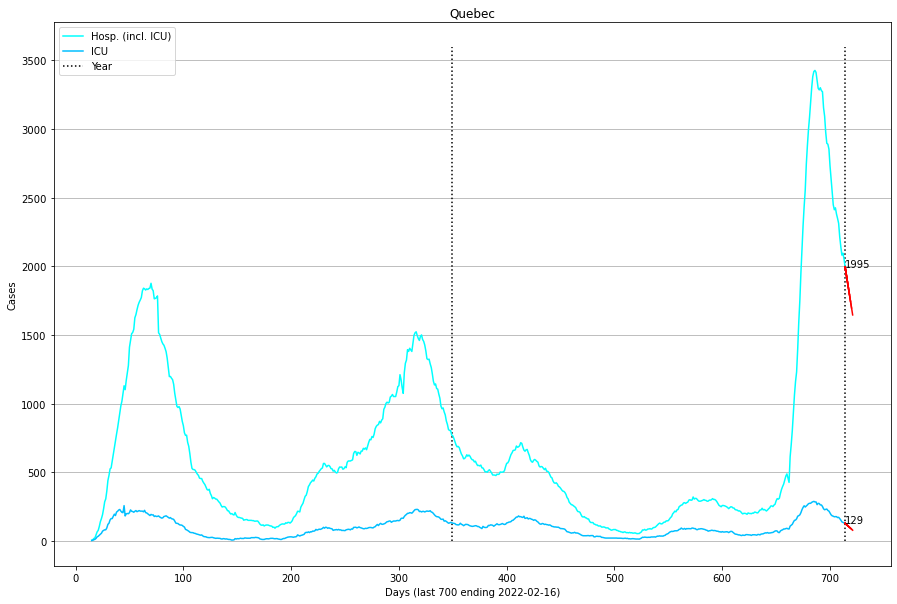

Quebec | Hospitalizations (incl. ICU): 1995 | ICU: 129


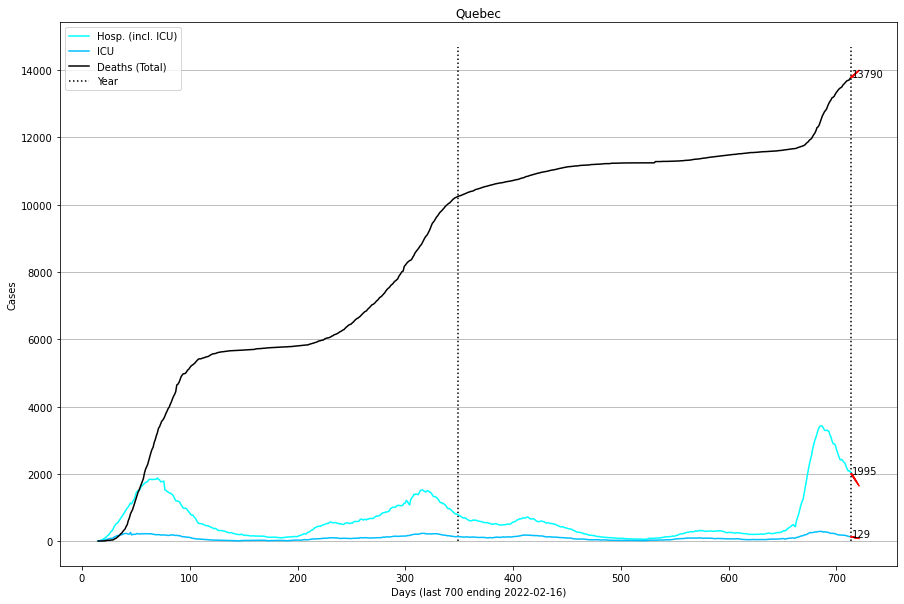

Quebec | Hospitalizations (incl. ICU): 1995 | ICU: 129 | Deaths: 13790


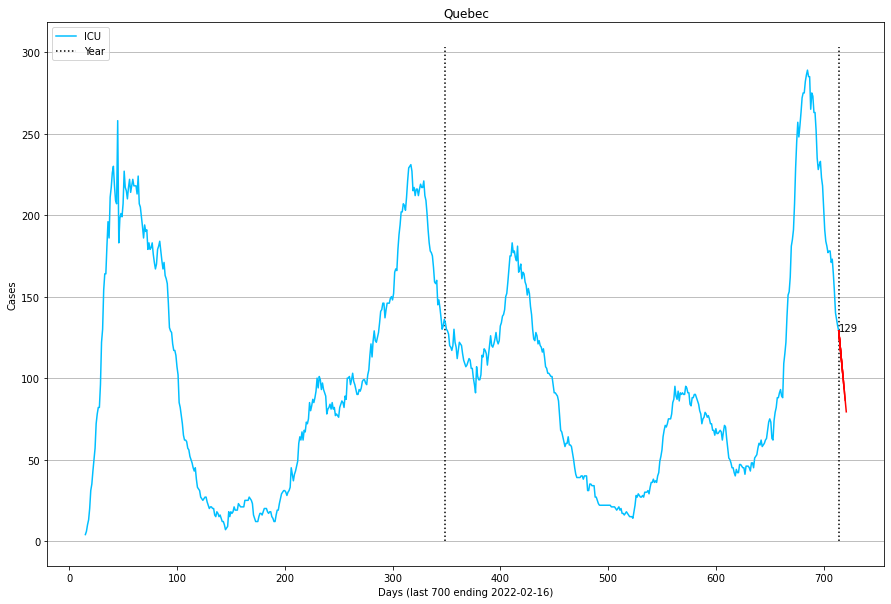

Quebec | ICU: 129


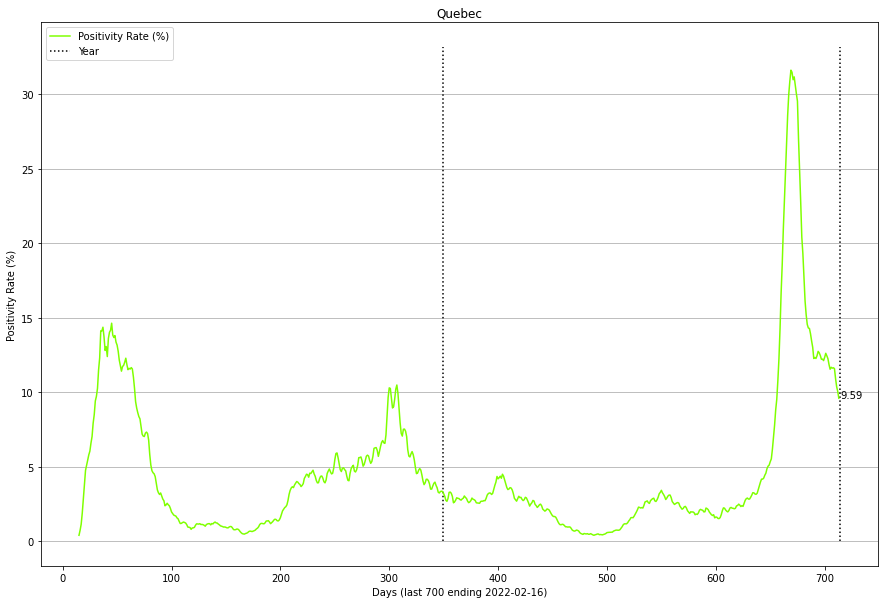

Quebec | Positivity Rate: 9 % (over 4 MA window)


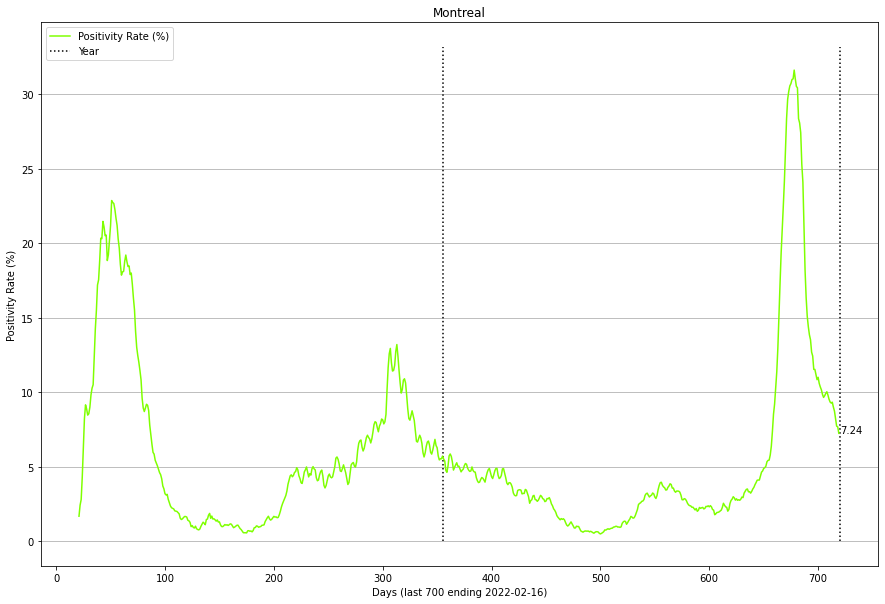

Montreal | Positivity Rate: 7 % (over 4 MA window)


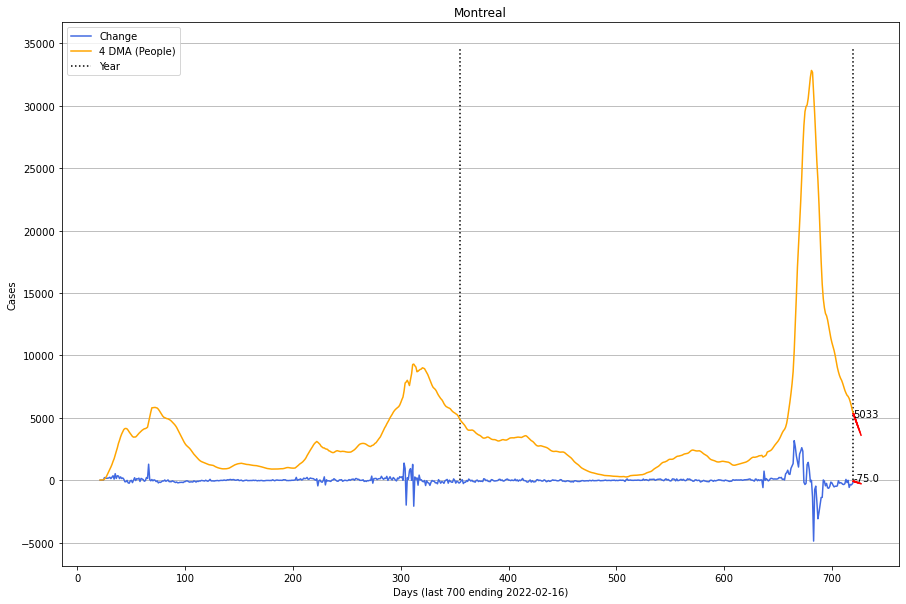

Montreal | Active: 5033 (Tip 4 DMA: 5318) | Change: -75


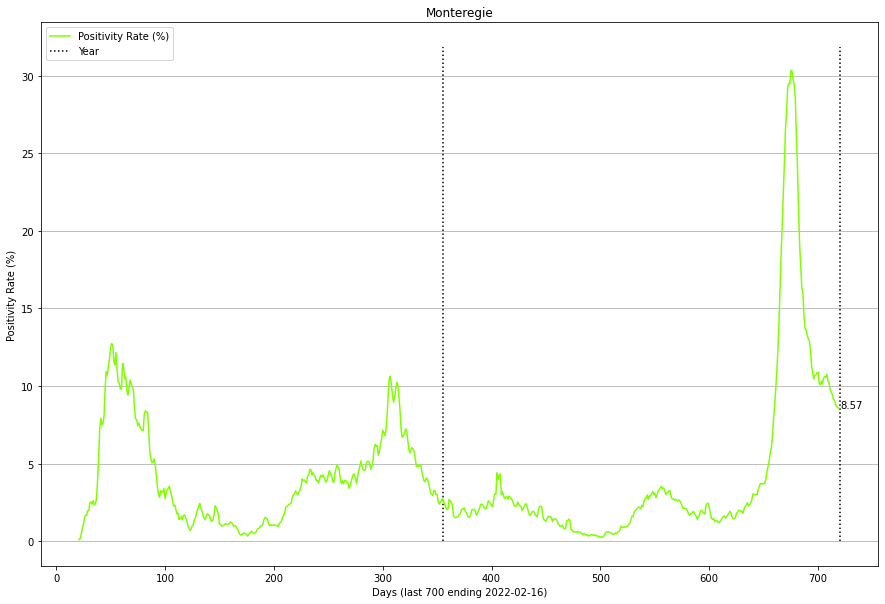

Monteregie | Positivity Rate: 8 % (over 4 MA window)


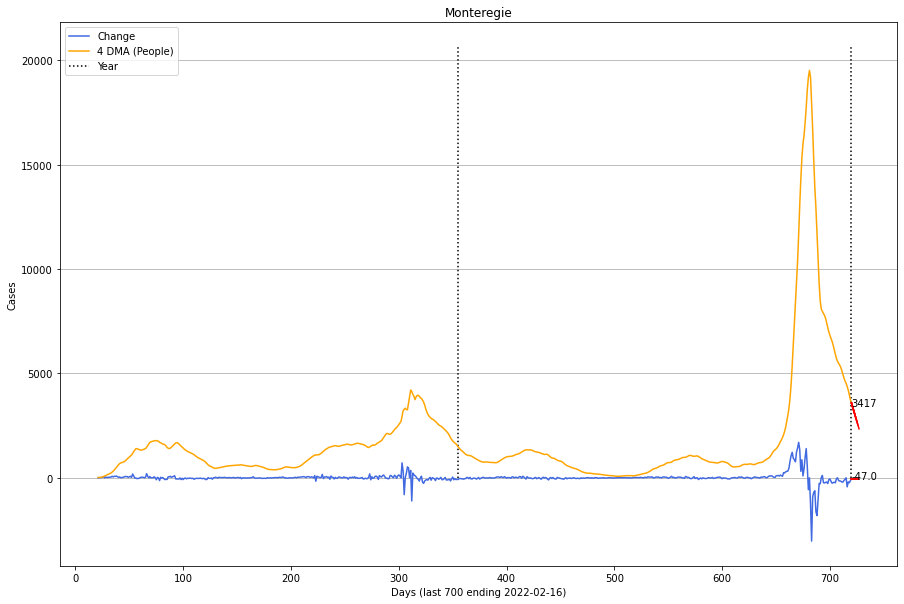

Monteregie | Active: 3417 (Tip 4 DMA: 3577) | Change: -47


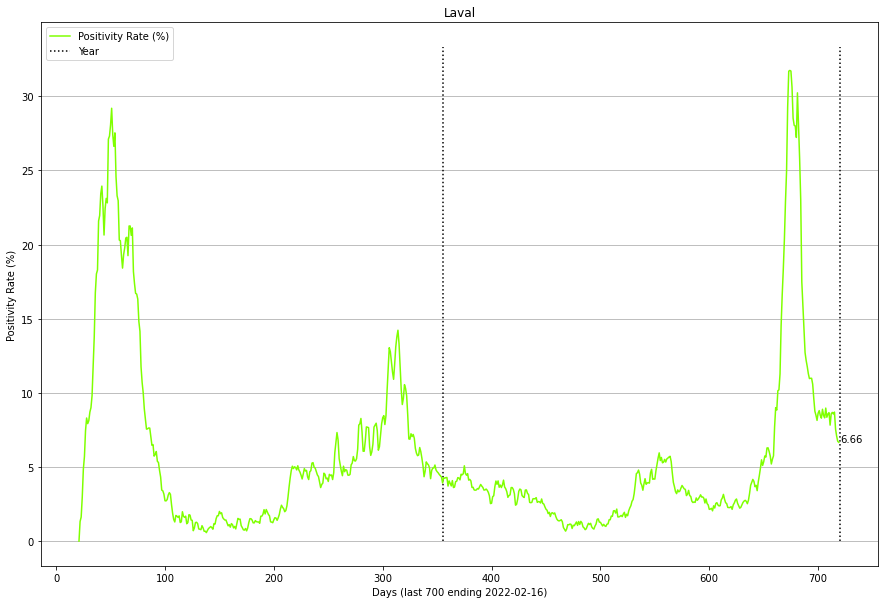

Laval | Positivity Rate: 6 % (over 4 MA window)


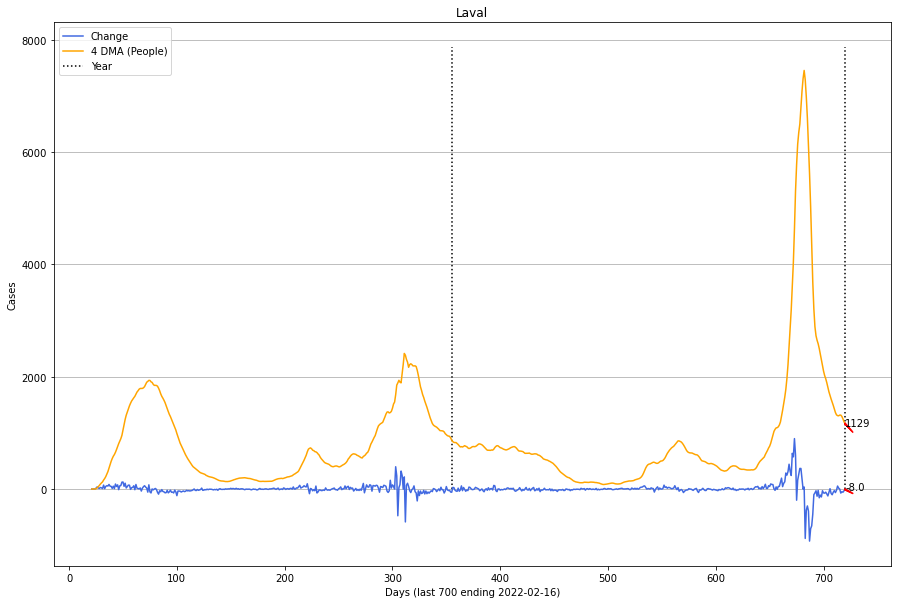

Laval | Active: 1129 (Tip 4 DMA: 1163) | Change: -8


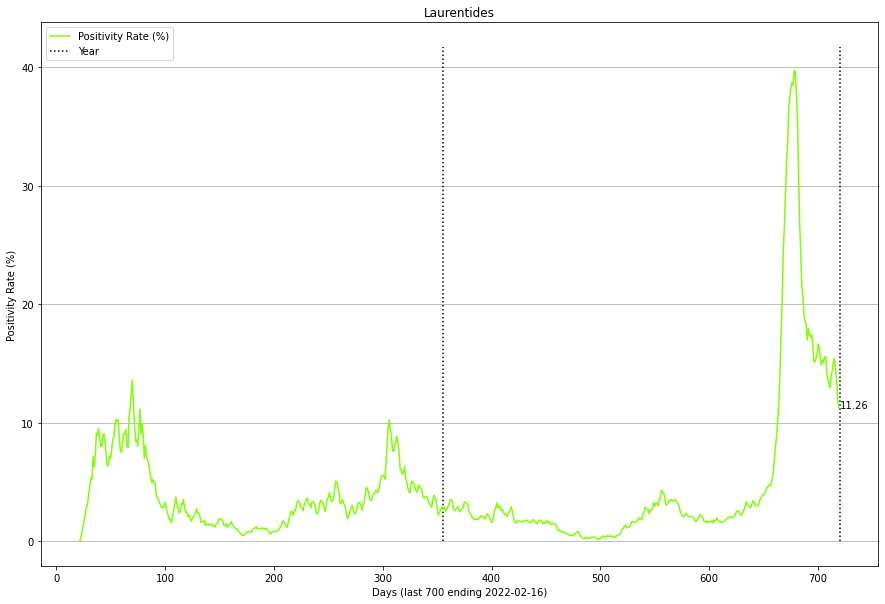

Laurentides | Positivity Rate: 11 % (over 4 MA window)


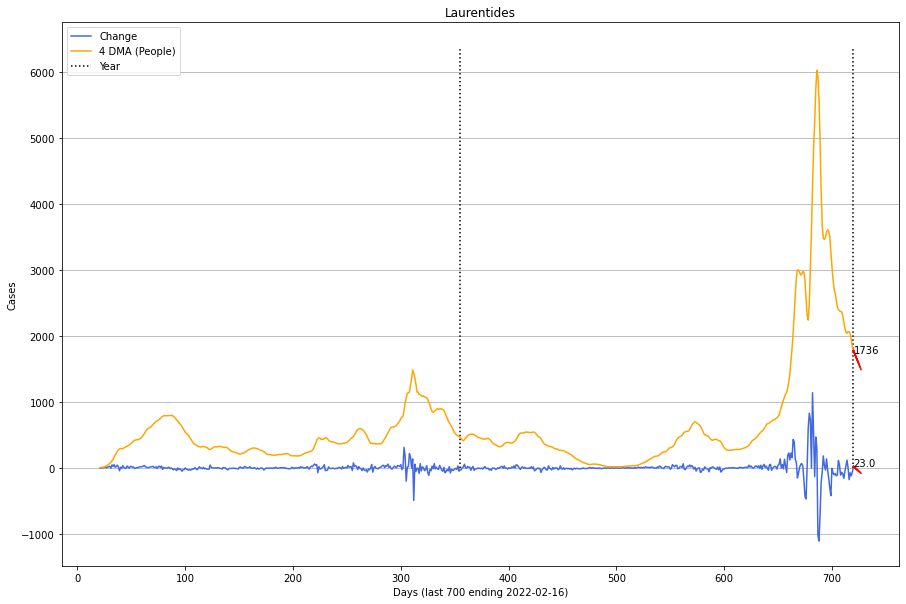

Laurentides | Active: 1736 (Tip 4 DMA: 1775) | Change: 23


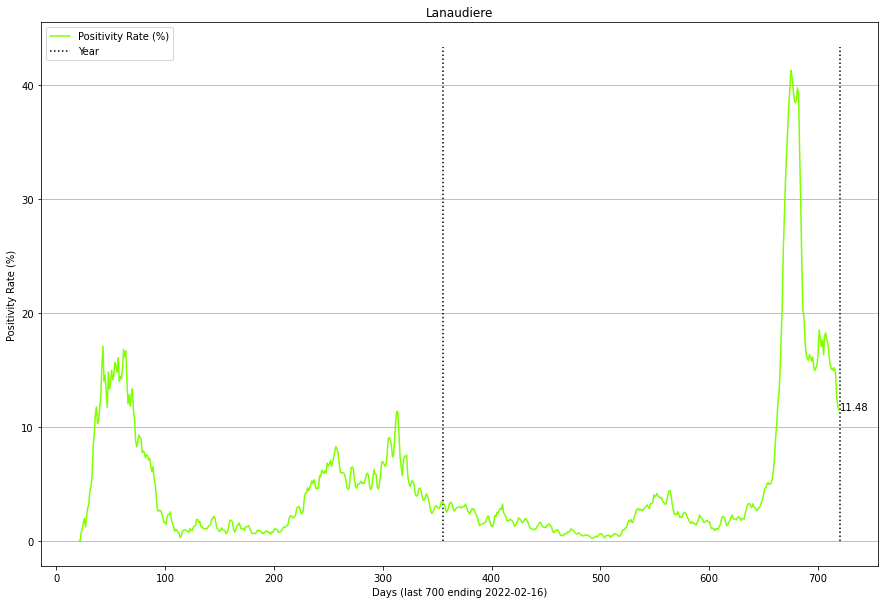

Lanaudiere | Positivity Rate: 11 % (over 4 MA window)


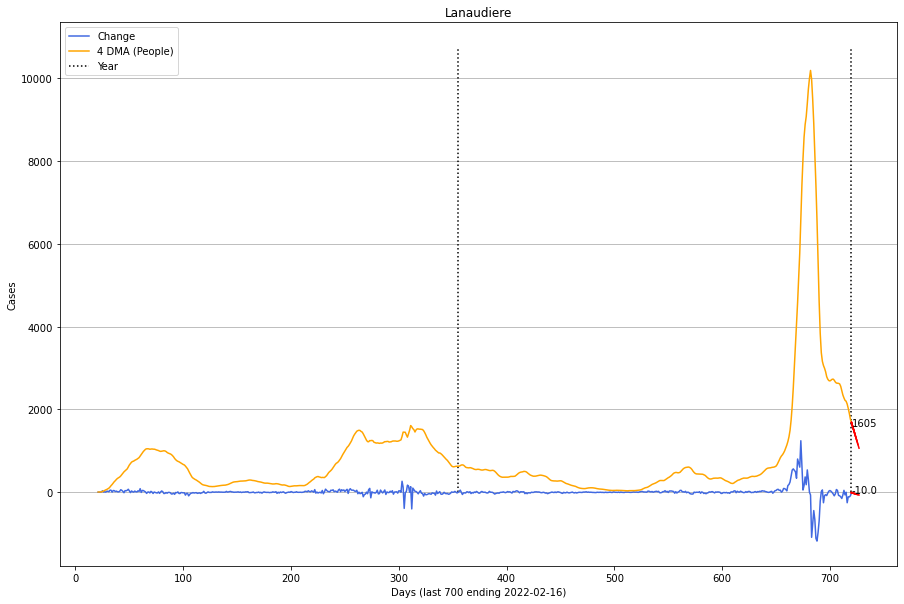

Lanaudiere | Active: 1605 (Tip 4 DMA: 1683) | Change: -10


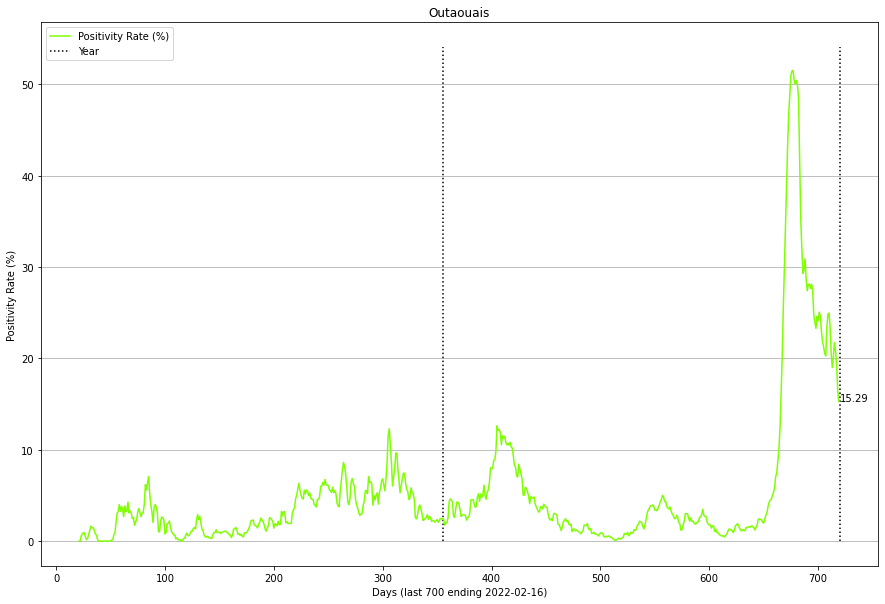

Outaouais | Positivity Rate: 15 % (over 4 MA window)


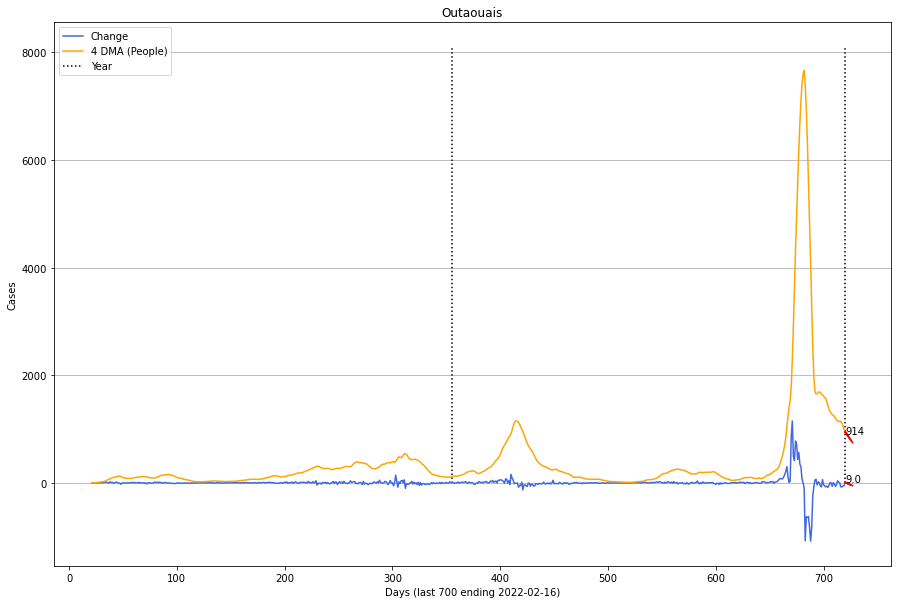

Outaouais | Active: 914 (Tip 4 DMA: 949) | Change: 9


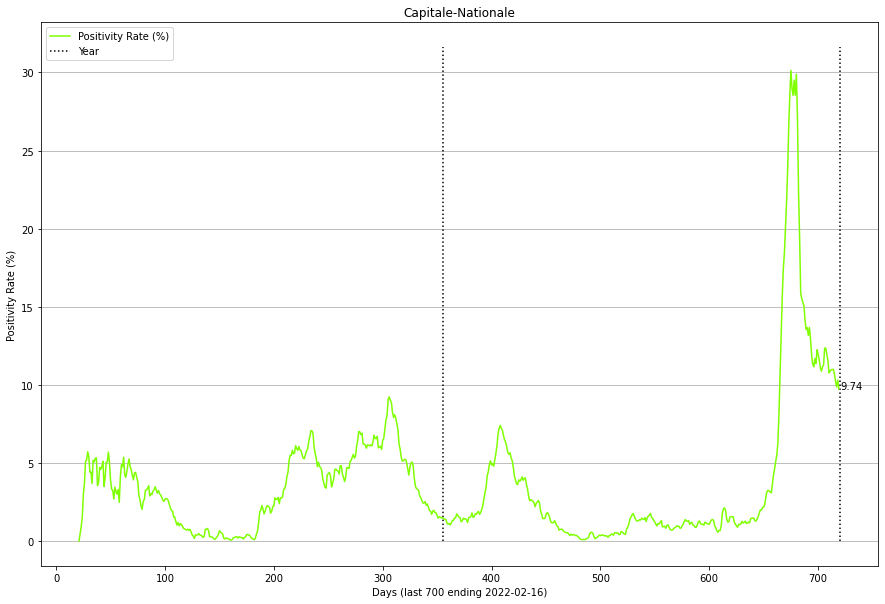

Capitale-nationale | Positivity Rate: 9 % (over 4 MA window)


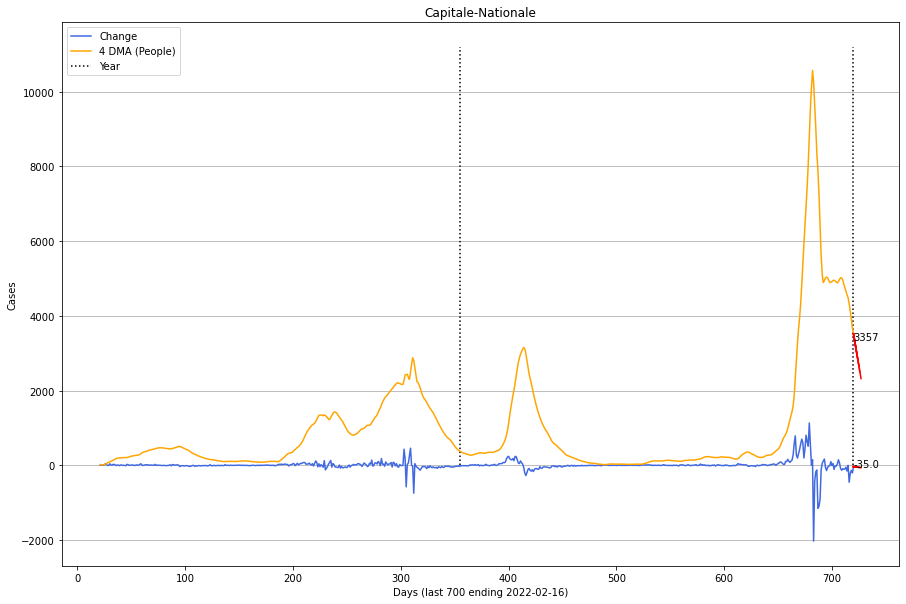

Capitale-nationale | Active: 3357 (Tip 4 DMA: 3519) | Change: -35


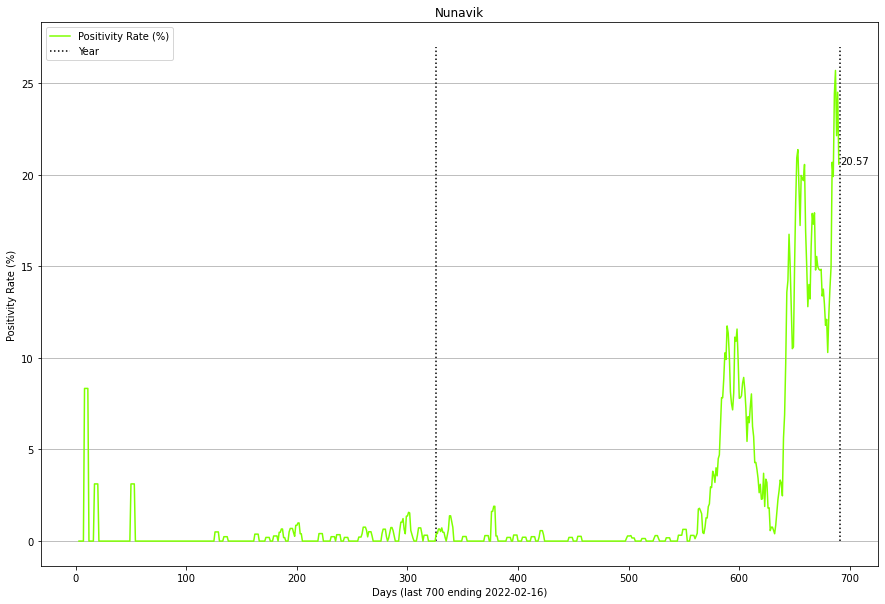

Nunavik | Positivity Rate: 20 % (over 4 MA window)


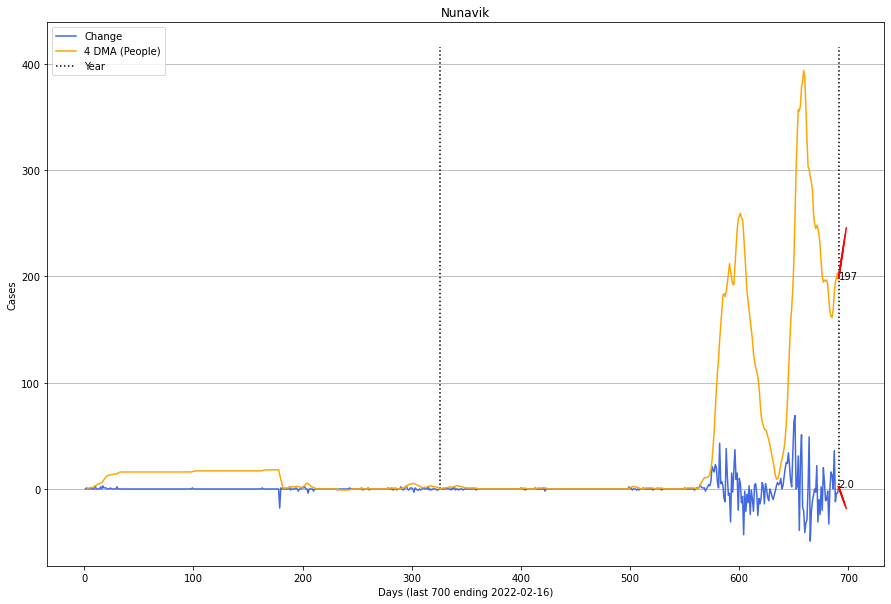

Nunavik | Active: 197 (Tip 4 DMA: 198) | Change: 2


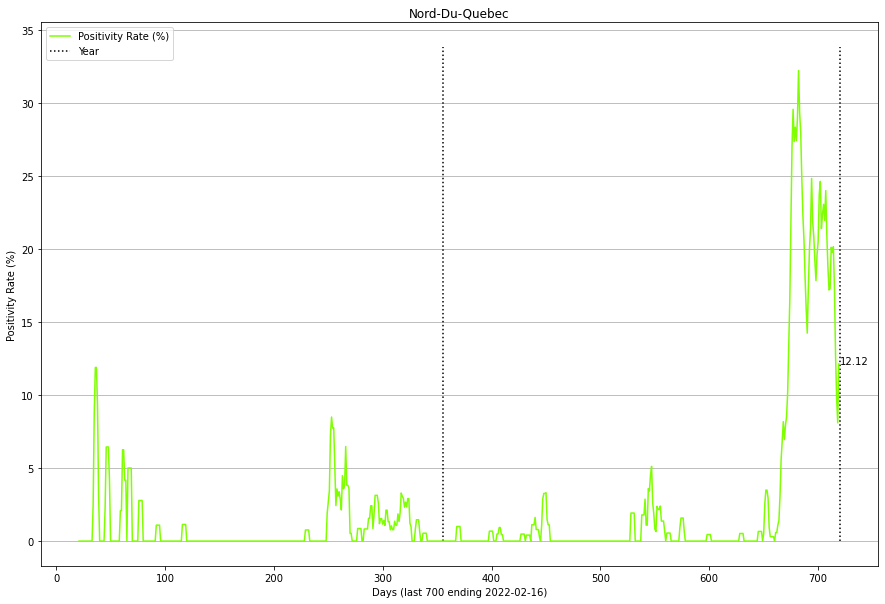

Nord-du-quebec | Positivity Rate: 12 % (over 4 MA window)


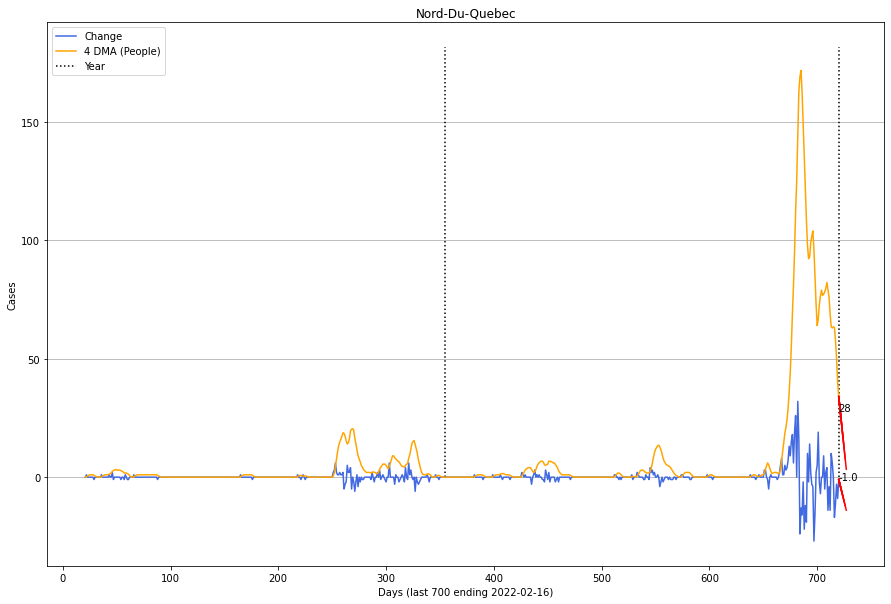

Nord-du-quebec | Active: 28 (Tip 4 DMA: 34) | Change: -1


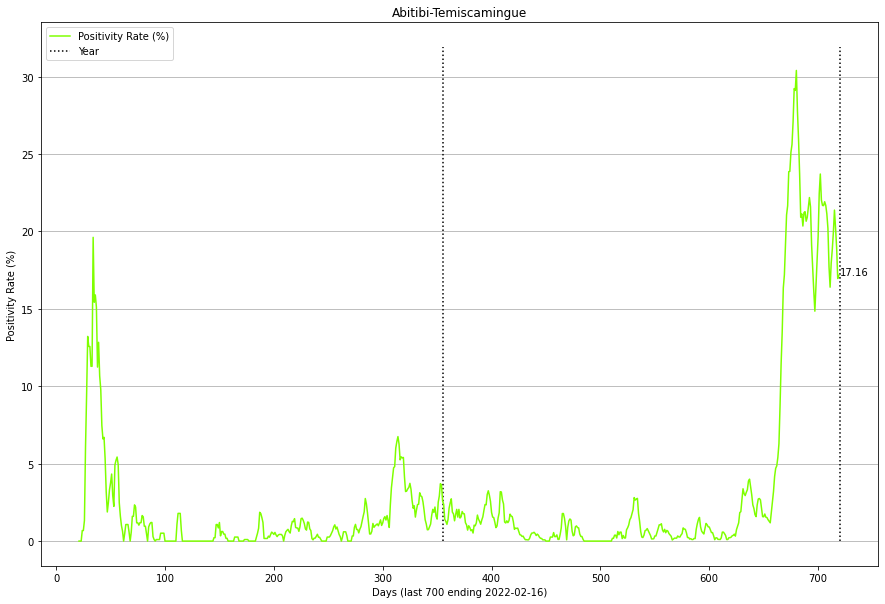

Abitibi-temiscamingue | Positivity Rate: 17 % (over 4 MA window)


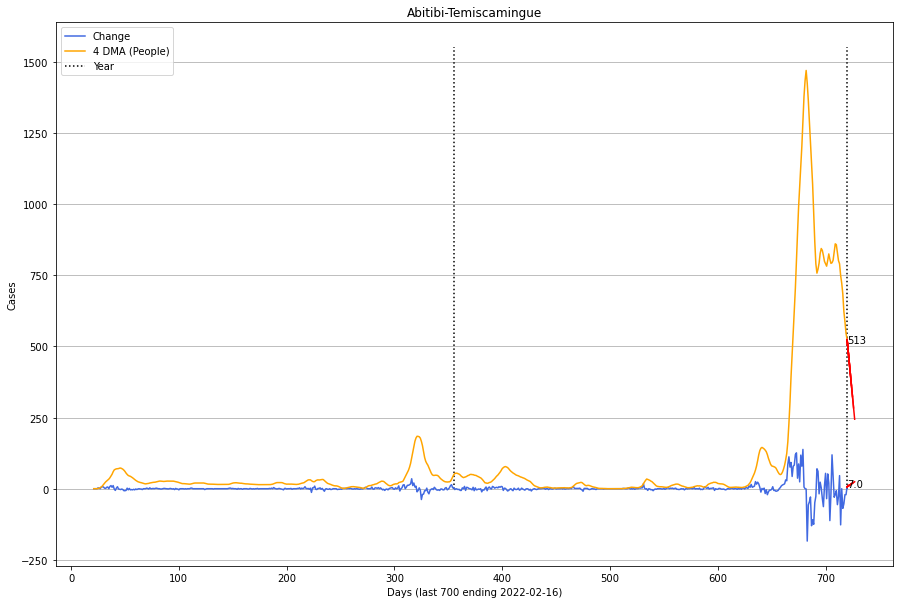

Abitibi-temiscamingue | Active: 513 (Tip 4 DMA: 523) | Change: 7


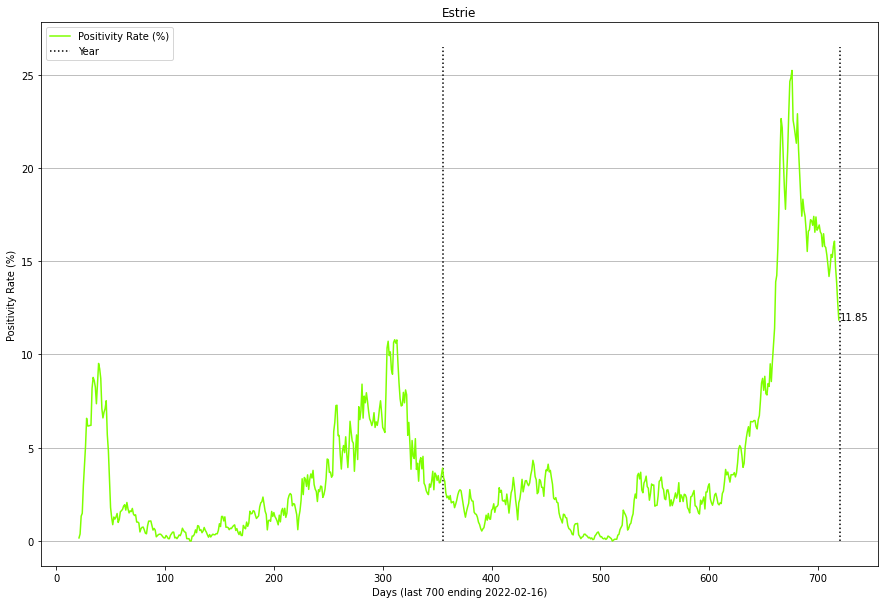

Estrie | Positivity Rate: 11 % (over 4 MA window)


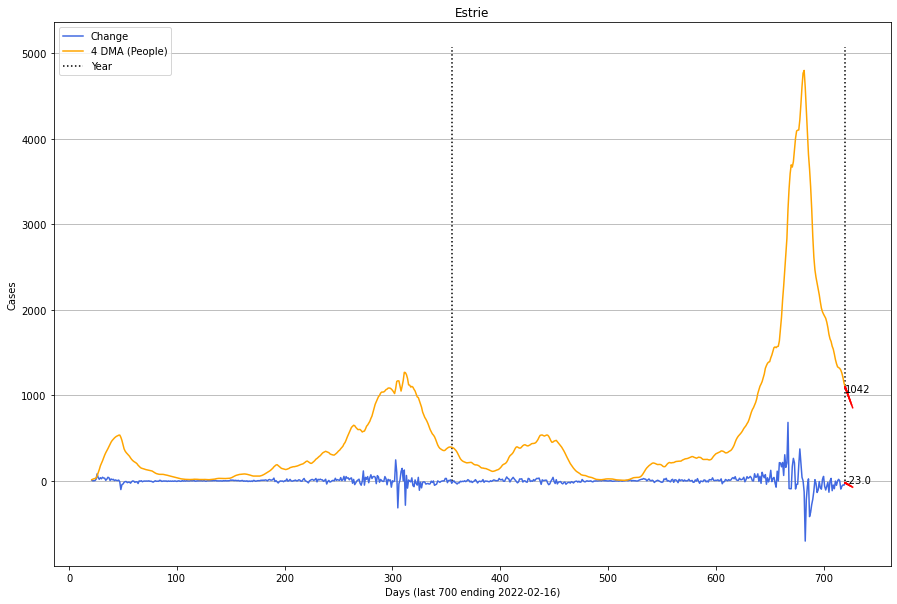

Estrie | Active: 1042 (Tip 4 DMA: 1096) | Change: -23


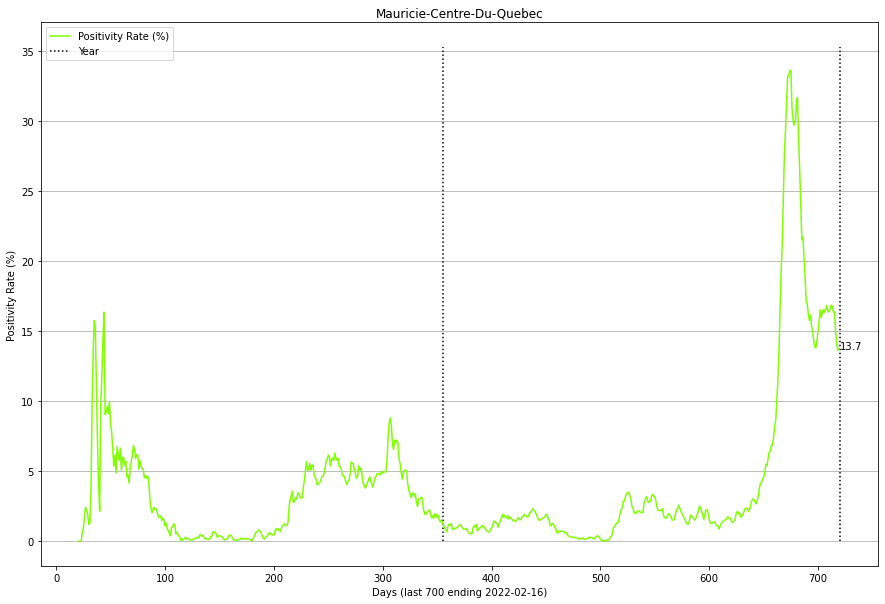

Mauricie-centre-du-quebec | Positivity Rate: 13 % (over 4 MA window)


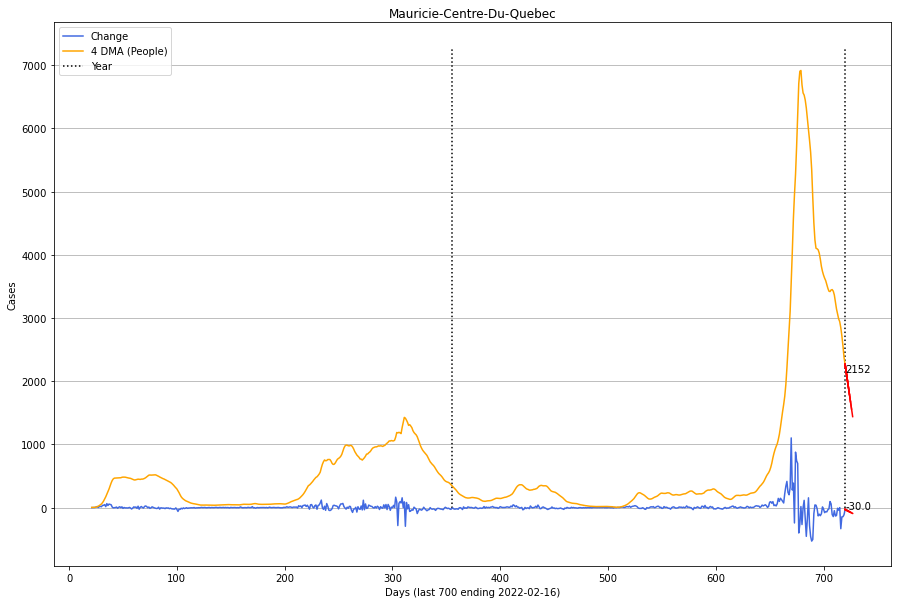

Mauricie-centre-du-quebec | Active: 2152 (Tip 4 DMA: 2267) | Change: -30


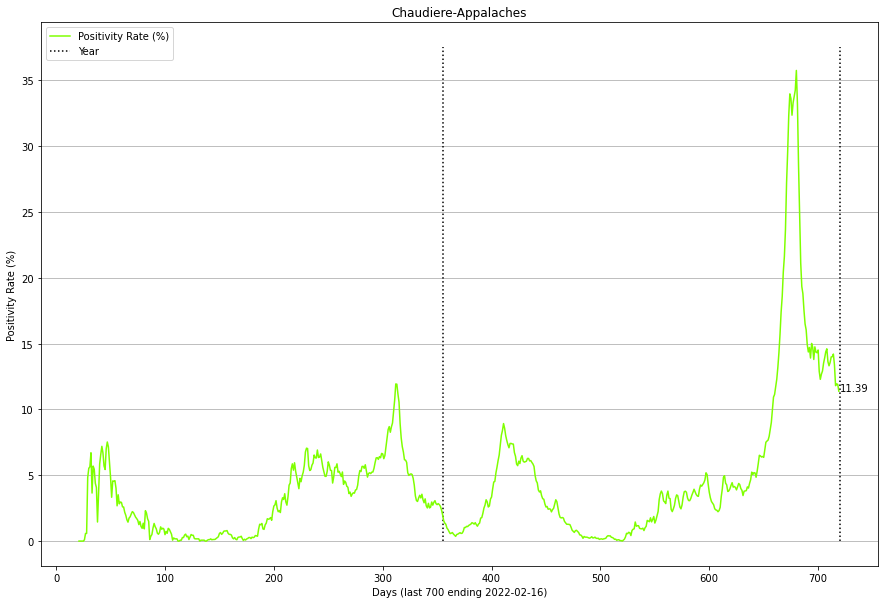

Chaudiere-appalaches | Positivity Rate: 11 % (over 4 MA window)


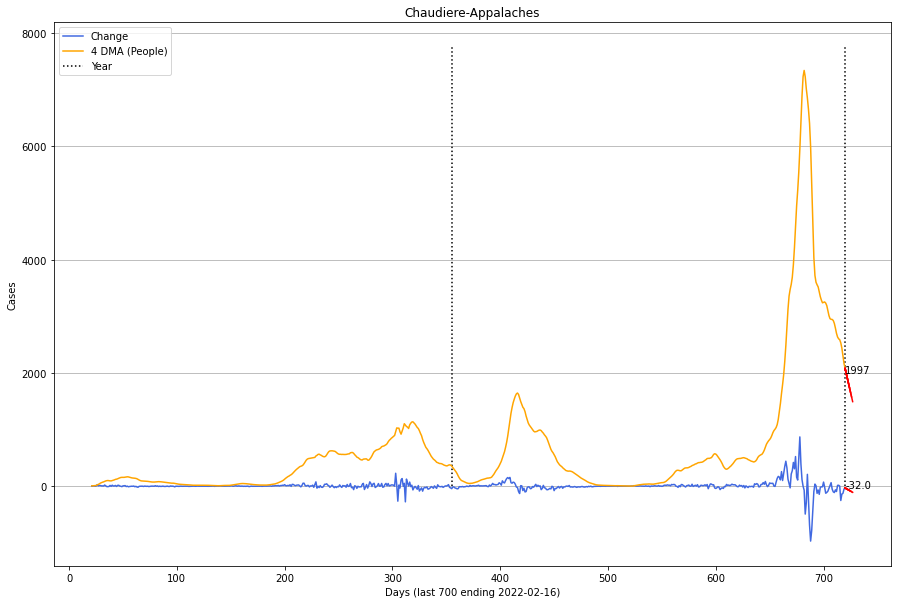

Chaudiere-appalaches | Active: 1997 (Tip 4 DMA: 2078) | Change: -32


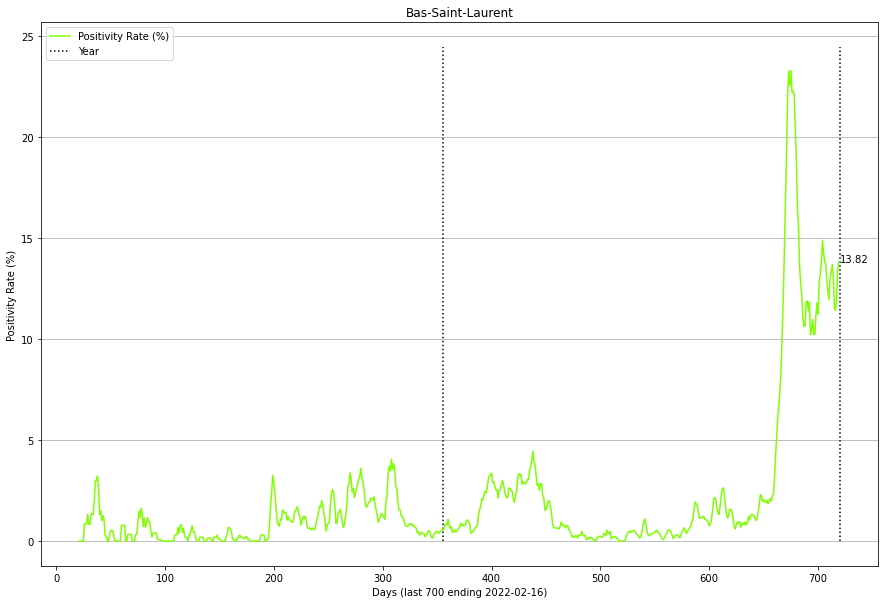

Bas-saint-laurent | Positivity Rate: 13 % (over 4 MA window)


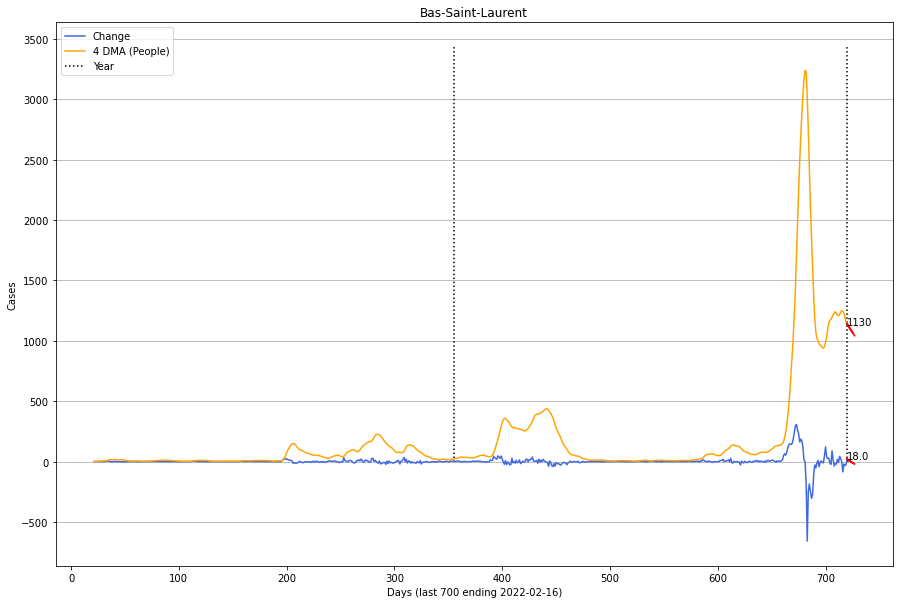

Bas-saint-laurent | Active: 1130 (Tip 4 DMA: 1137) | Change: 18


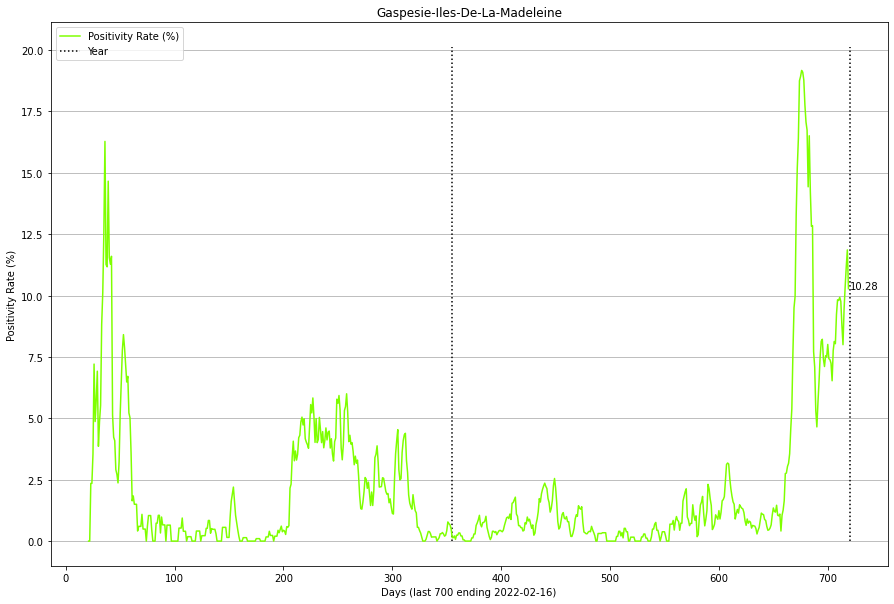

Gaspesie-iles-de-la-madeleine | Positivity Rate: 10 % (over 4 MA window)


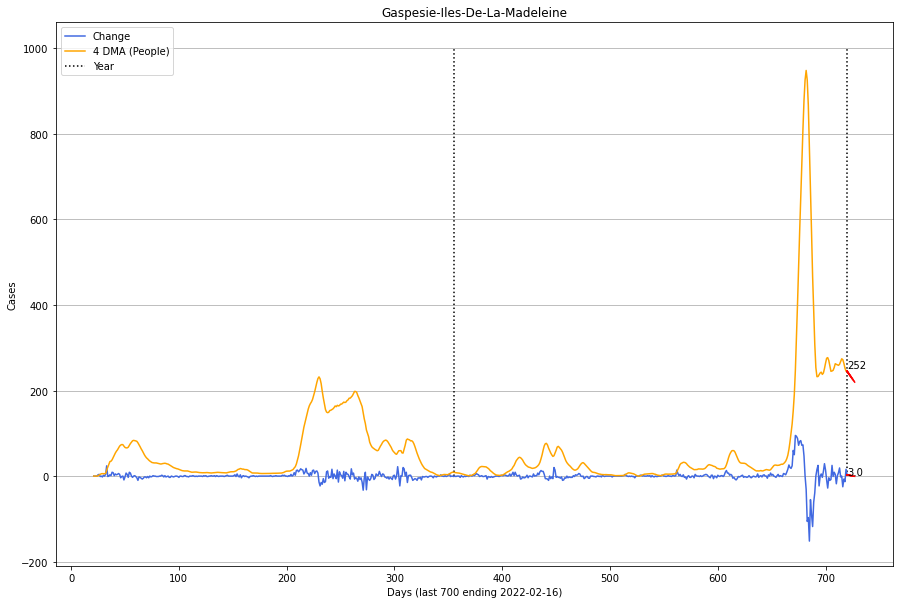

Gaspesie-iles-de-la-madeleine | Active: 252 (Tip 4 DMA: 245) | Change: 3


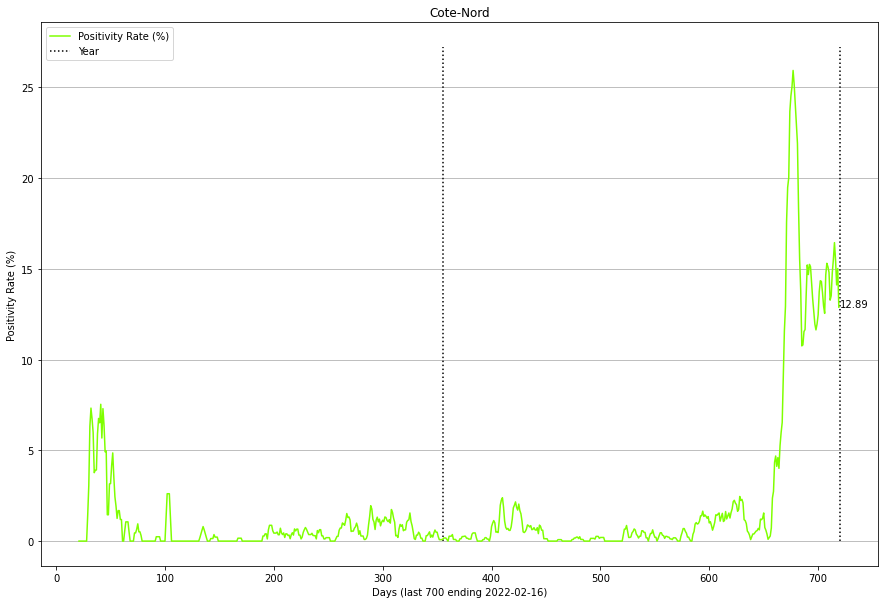

Cote-nord | Positivity Rate: 12 % (over 4 MA window)


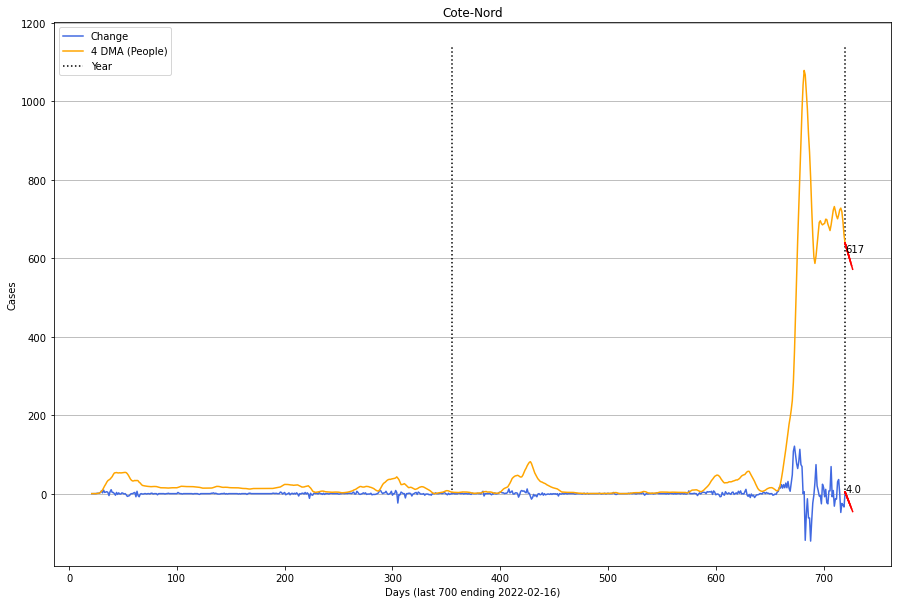

Cote-nord | Active: 617 (Tip 4 DMA: 638) | Change: 4


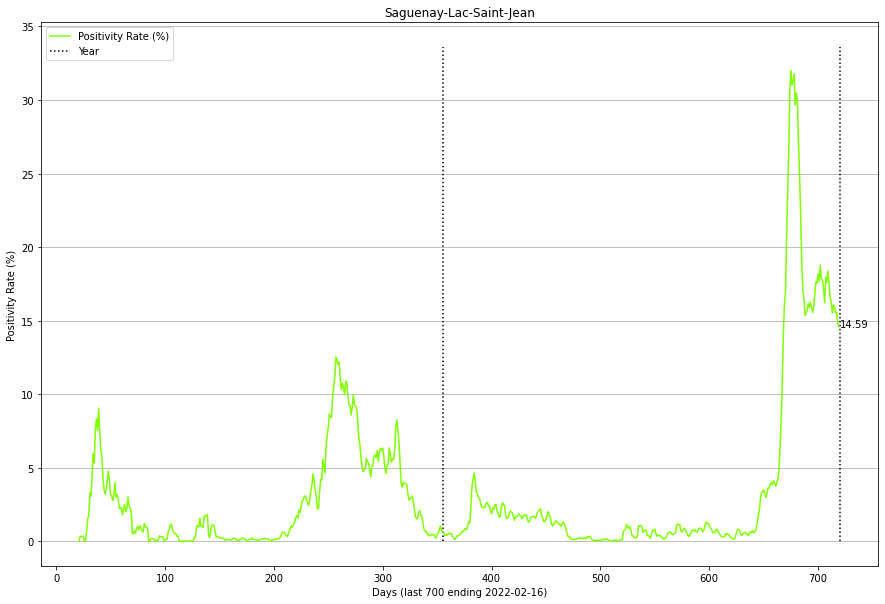

Saguenay-lac-saint-jean | Positivity Rate: 14 % (over 4 MA window)


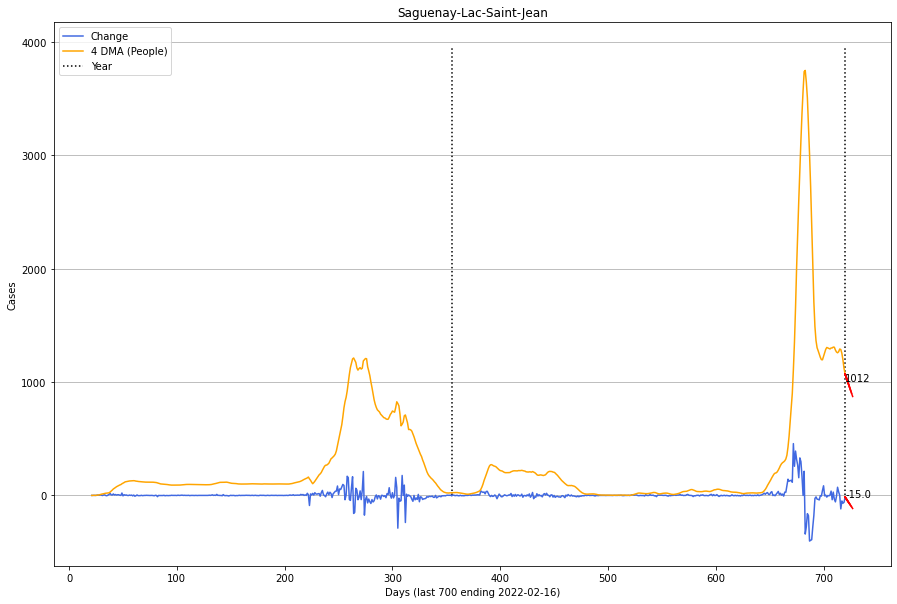

Saguenay-lac-saint-jean | Active: 1012 (Tip 4 DMA: 1071) | Change: -15


In [4]:
qcdf = get()

plot(df=qcdf, Region="Quebec", Hospitalizations=True, ICU=True, Extrapolate=True)
plot(df=qcdf, Region="Quebec", Deaths=True, Hospitalizations=True, ICU=True, Extrapolate=True)
plot(df=qcdf, Region="Quebec", ICU=True, Extrapolate=True)
plot(df=qcdf, Region="Quebec", Positivity=True, Extrapolate=True)

for r in REGIONS:
    df = get(r)
    plot(df=df, Region=r, Positivity=True, Change=False, MA=False, New=False, Extrapolate=False, Vaccinations=False)
    plot(df=df, Region=r, Change=True, MA=True, New=False, Extrapolate=True)